In [0]:
from io import open
import glob
import os
import unicodedata
import string
import pandas as pd
import numpy as np

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
   return glob.glob(path)

In [0]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [0]:
# Build the category_lines dictionary, a list of lines per category
category_lines = []
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_line = [category] * len(lines)
    category_lines.extend(list(zip(category_line, lines)))

n_categories = len(all_categories)


In [0]:
all_categories = {v:k for k,v in enumerate(all_categories)}

In [0]:
# One-hot vector for category
def categoryArray(cat):
    arr = np.zeros(n_categories)
    arr[cat] = 1
    return arr

In [7]:
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 {'Czech': 0, 'English': 1, 'Scottish': 2, 'Italian': 3, 'Polish': 4, 'Greek': 5, 'Dutch': 6, 'German': 7, 'Japanese': 8, 'Korean': 9, 'Arabic': 10, 'Portuguese': 11, 'Russian': 12, 'Vietnamese': 13, 'Irish': 14, 'Spanish': 15, 'French': 16, 'Chinese': 17}
O'Neal


In [0]:
df = pd.DataFrame(category_lines, columns=['category_','name'])
df['len'] = df['name'].apply(lambda s: len(s))
df['category'] = df['category_'].apply(lambda c: all_categories[c])
df['category'] = df['category'].apply(lambda c: categoryArray(c))

In [0]:
df = df.sample(n=len(df))

In [10]:
max_len = df.len.max()
print(max_len)

20


In [0]:
lista_completa = df[['category','name']].values

In [0]:
import itertools
from collections import Counter

cosa = list(itertools.chain(lista_completa[:,1]))
cosa_word = sorted(list(set(list(itertools.chain.from_iterable(cosa)))))

In [13]:
dict_words = {}
dict_words['[UNK]'] = 0
dict_words['[EOS]'] = 1
dict_words['[PAD]'] = 2
dict_words.update({v:k for k,v in enumerate(cosa_word,3)})
int_2_vocab = {v:k for k,v in dict_words.items()}
n_words = len(dict_words)
print(n_words)

59


In [0]:
cosa = [[dict_words.get(j,0) for j in d] + [dict_words['[EOS]']] for d in lista_completa[:,1]]

In [0]:
# ''.join([int_2_vocab[i] for i in cosa[0]])

In [0]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = dict_words['[PAD]']*np.ones((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, :len(row)] = np.array(row)[:seq_length]
    
    return features

In [0]:
features = pad_features(cosa, max_len + 1)

In [18]:
''.join([int_2_vocab[i] for i in features[0]])

'Dagher[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

In [0]:
category_features = lista_completa[:,0]
category_features = np.expand_dims(category_features, axis=0).transpose(1,0)

In [0]:
all_features = np.concatenate((category_features, features), axis=1)

In [0]:
import torch

# One-hot matrix of first to last letters (not including EOS) for input
def inputArray(line):
    category_index_input = line[:,0]
    category_index_input = np.stack(category_index_input, axis=0)
    word_indexes_input = line[:,1:]
    word_indexes_target = line[:,2:]
    to_append = np.array([word_indexes_target.shape[0]*[dict_words['[PAD]']]]).transpose(1,0)
    word_indexes_target = np.concatenate((word_indexes_target, to_append), axis=1)
    return category_index_input, word_indexes_input, word_indexes_target

In [0]:
cat_inputs, inputs, targets = inputArray(all_features)

In [0]:
inputs = inputs.astype('int64')
targets = targets.astype('int64')

In [24]:
split_frac = 0.9

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(inputs)*split_frac)
train_x, remaining_x = inputs[:split_idx], inputs[split_idx:]
train_y, remaining_y = targets[:split_idx], targets[split_idx:]
train_cat, remaining_cat = cat_inputs[:split_idx], cat_inputs[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]
val_cat, test_cat = remaining_cat[:test_idx], remaining_cat[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(18066, 21) 
Validation set: 	(1004, 21) 
Test set: 		(1004, 21)


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_cat), torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_cat), torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_cat), torch.from_numpy(test_x), torch.from_numpy(test_y))

In [0]:
# dataloaders
BATCH_SIZE = 64

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.n_layers = n_layers
        self.hid_dim = hid_dim

        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx = 2)

        self.rnn = nn.GRU(n_categories + embed_dim,
                        hid_dim, 
                        num_layers=n_layers, 
                        dropout = 0 if n_layers < 2 else dropout)

        self.fc = nn.Linear(hid_dim, input_dim)

    def forward(self, cat, inputs, hidden):

        #cat = [batch size, n_cats]

        #inputs = [batch size]

        emb = self.embedding(inputs)

        #emb = [batch size, emb dim]

        combined_input = torch.cat((cat, emb), 1)

        #combined_input = [batch size, n_cats + emb dim]

        combined_input = combined_input.unsqueeze(0)

        # combined_input = [1, batch size, n_cats + emb dim]

        output, hidden = self.rnn(combined_input, hidden)

        #output = [1, batch size, hid dim * num directions dim]
        #hidden = [n layers * num directions, batch size, hid dim]

        output = self.fc(output)

        #output = [1, batch size, input dim]

        output = output.view(-1, self.input_dim)

        #output = [batch size*1, input_dim] == [batch size, input dim]

        return F.log_softmax(output, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())

        return weight.new_zeros(self.n_layers, bsz, self.hid_dim)

In [0]:
embed_dim = 50
hid_dim = 128
n_layers = 1
dropout = 0.1

model = RNN(n_words, embed_dim, hid_dim, n_layers, dropout)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 86,593 trainable parameters


In [0]:
import torch.optim as optim

criterion = nn.NLLLoss()

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
learning_rate = 0.0003
optimizer = optim.Adam(model.parameters(), learning_rate)

In [0]:
def train(model, iterator, optimizer, criterion):
    total_loss = 0
    model.train()
    
    j = 0
    
    for categories, inputs, targets in iterator:
        bsz = inputs.shape[0]
        hidden = model.init_hidden(bsz)
        hidden = hidden.to(device)
        loss = 0
        categories, inputs, targets = categories.to(device), inputs.to(device), targets.to(device)
        
        inputs = inputs.transpose(1,0)
        targets = targets.transpose(1,0)

        categories = categories.float()
        inputs = inputs.long()
        targets = targets.long()
        
        seq_len_batched = inputs.shape[0]


        optimizer.zero_grad()
        
        hidden = hidden.detach()
      
        for i in range(seq_len_batched):
            output, hidden = model(categories, inputs[i], hidden)
            loss += criterion(output, targets[i])
            
        loss.backward()
        
        optimizer.step()
        
        epoch_loss = loss.item()/seq_len_batched
        
        total_loss += epoch_loss
        
        j += 1
        
        if j % log_interval == 0:
            cur_loss = epoch_loss #/ log_interval
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, j, len(iterator), learning_rate,
                cur_loss, math.exp(cur_loss)))
            total_loss = 0
            # example,_,_ = sample('practicante derecho,abogado')
            # print(example)
        
    return total_loss / len(iterator)


def evaluate(model, iterator, criterion):
    
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
    
        for categories, inputs, targets in iterator:
            bsz = inputs.shape[0]
            hidden = model.init_hidden(bsz)
            hidden = hidden.to(device)
            
            loss = 0
            
            categories, inputs, targets = categories.to(device), inputs.to(device), targets.to(device)

            inputs = inputs.transpose(1,0)
            targets = targets.transpose(1,0)

            categories = categories.float()
            inputs = inputs.long()
            targets = targets.long()

            seq_len_batched = inputs.shape[0]
            
            for i in range(seq_len_batched):
                output, hidden = model(categories, inputs[i], hidden)
                loss += criterion(output, targets[i])
            
            epoch_loss = loss.item()/seq_len_batched 
            total_loss += epoch_loss
        
    return total_loss / len(iterator)

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
N_EPOCHS = 50

best_valid_loss = float('inf')
counter = 0
patience = 5
log_interval = 25
plot_every = 10
train_loses = []
valid_loses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    train_loses.append(train_loss)
    valid_loses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut2-model.pt')
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            break

| epoch   0 |    25/  283 batches | lr 0.0003 | loss  3.61 | ppl    36.89
| epoch   0 |    50/  283 batches | lr 0.0003 | loss  1.45 | ppl     4.25
| epoch   0 |    75/  283 batches | lr 0.0003 | loss  1.31 | ppl     3.70
| epoch   0 |   100/  283 batches | lr 0.0003 | loss  1.31 | ppl     3.71
| epoch   0 |   125/  283 batches | lr 0.0003 | loss  1.15 | ppl     3.15
| epoch   0 |   150/  283 batches | lr 0.0003 | loss  1.15 | ppl     3.15
| epoch   0 |   175/  283 batches | lr 0.0003 | loss  1.06 | ppl     2.89
| epoch   0 |   200/  283 batches | lr 0.0003 | loss  1.09 | ppl     2.98
| epoch   0 |   225/  283 batches | lr 0.0003 | loss  1.00 | ppl     2.72
| epoch   0 |   250/  283 batches | lr 0.0003 | loss  0.95 | ppl     2.59
| epoch   0 |   275/  283 batches | lr 0.0003 | loss  1.02 | ppl     2.77
Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.027 | Val. Loss: 0.948
| epoch   1 |    25/  283 batches | lr 0.0003 | loss  0.98 | ppl     2.67
| epoch   1 |    50/  283 batches | lr 0.000

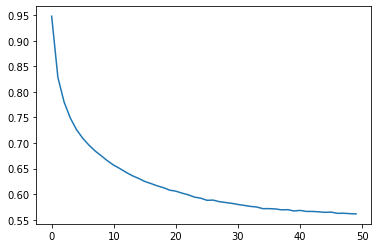

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
# plt.plot(train_loses)
plt.plot(valid_loses)

In [38]:
evaluate(model, test_loader, criterion)

0.5631688719704038

In [0]:
def sample(category_, prime_str, predict_len = 10):
    cat_input = categoryArray(all_categories[category_])
    cat_tensor = torch.tensor(cat_input).unsqueeze(0).float()
    word_indexes = [dict_words[li] for li in prime_str]
    prime_input = torch.tensor(word_indexes).unsqueeze(1)
    prime_input = prime_input.to(device)
    cat_tensor = cat_tensor.to(device)
    hidden = model.init_hidden(1)
    hidden = hidden.to(device)
    # Use priming string to "build up" hidden state
    with torch.no_grad():
        for p in range(len(prime_str) - 1):
            _, hidden = model(cat_tensor, prime_input[p], hidden)

        inp = prime_input[-1]
        inp = inp.to(device)
        predicted = prime_str
        tops = []
        for i in range(predict_len):
            output, hidden = model(cat_tensor, inp, hidden)
            topv, topp = output.topk(1)
            _, topps = output.topk(20)
            tops.append(topps)
            topi = topp[0][0].item()
            if topi == 1:
                break   
            else:
                letter = int_2_vocab[topi]
                predicted += letter
            inp = [dict_words[letter]]
            inp = torch.tensor(inp).to(device)

    return predicted

In [42]:
sample('Italian',"Vit")

'Vitori'

In [43]:
sample('Italian','Rimin')

'Rimino'

In [0]:
df[df['category_']=='Italian']

,category_,name,len,category
4447,Italian,Bartalotti,10,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4292,Italian,Abatescianni,12,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4368,Italian,Albrici,7,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4886,Italian,Sapienti,8,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4899,Italian,Scotti,6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
4979,Italian,Vico,4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4611,Italian,Fierro,6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4301,Italian,Abbiati,7,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4650,Italian,Guttuso,7,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
